In [5]:
import time
import torch
from torch.distributions import Categorical, kl
import numpy as np
from tqdm.auto import tqdm
# from d2l.torch import Animator

from net_deepaco import Net as Net_DeepACO
from net import Net
from aco import ACO
from faco import FACO
from utils import gen_pyg_data, load_test_dataset

torch.manual_seed(12345)

EPS = 1e-10
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print(f'Using device: {device}')

Using device: cuda:0


In [6]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
%matplotlib inline

In [7]:
from copy import copy
from train import prepare_pyg_for_step, local_two_opt_fast
from utils import gen_pyg_data, load_test_dataset


MIN_NEW_EDGES = 8
K_NEAREST = 20
SAMPLE_TWO_OPT = False  # Use external 2-opt like training
INV_TEMP = 1.0
T_eval = 5

@torch.no_grad()
def infer_instance(model, demands, distances, n_ants, t_aco_diff, visualize=False, return_timing=False):
    model.eval()
    
    timing = {}
    
    t_start = time.time()
    pyg_base = gen_pyg_data(demands, distances, device, k_nearest=K_NEAREST)
    timing['gen_pyg'] = time.time() - t_start
    
    results = torch.zeros(size=(len(t_aco_diff),), device=device)

    t_start = time.time()
    solver = FACO(
        distances=distances,
        demand=demands,
        n_ants=n_ants,
        k_nearest=K_NEAREST,
        capacity=50,
        decay=0.9,
        alpha=1.0,
        beta=1.0,
        min_new_edges=MIN_NEW_EDGES,
        sample_two_opt=SAMPLE_TWO_OPT,
        device=device,
    )
    timing['faco_init'] = time.time() - t_start
    
    # Precompute distance matrix for local_two_opt
    dist_np = distances.detach().cpu().numpy()

    if visualize:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        fig.suptitle('Heuristic Matrix Evolution')
        cbar1, cbar2 = None, None

    # baseline (first step sampling mean)
    t_start = time.time()
    ref_flat = solver.best_flat.copy()
    tau = solver.pheromone_sparse.detach().clone()
    pyg = prepare_pyg_for_step(pyg_base, solver, ref_flat, tau)
    
    out = model(pyg, return_value=True)
    heu_vec = out[0] if isinstance(out, tuple) else out
    heu_full = model.reshape(pyg, heu_vec) + 1e-10
    solver.set_heuristic(heu_full)
    timing['init_model'] = time.time() - t_start

    # Sample with require_prob=True to get touched for external 2-opt
    t_start = time.time()
    costs_raw, flats_raw, touched_list, _, _ = solver.sample(invtemp=INV_TEMP, require_prob=True)
    timing['init_sample'] = time.time() - t_start
    
    # Apply external local 2-opt (consistent with training)
    t_start = time.time()
    flats_post = []
    costs_post = []
    for a in range(n_ants):
        flat2, cost2 = local_two_opt_fast(flats_raw[a], touched_list[a], dist_np, solver.n)
        flats_post.append(flat2)
        costs_post.append(cost2)
    costs_np = np.array(costs_post, dtype=np.float32)
    timing['init_2opt'] = time.time() - t_start
    
    # Per-iteration timing accumulators
    timing['prepare_total'] = 0.0
    timing['model_total'] = 0.0
    timing['sample_total'] = 0.0
    timing['2opt_total'] = 0.0
    timing['update_total'] = 0.0

    T_eval = t_aco_diff[-1]
    for _t in range(T_eval):
        t_start = time.time()
        ref_flat = solver.best_flat.copy()
        tau = solver.pheromone_sparse.detach().clone()
        pyg = prepare_pyg_for_step(pyg_base, solver, ref_flat, tau)
        timing['prepare_total'] += time.time() - t_start

        t_start = time.time()
        out = model(pyg, return_value=True)
        heu_vec = out[0] if isinstance(out, tuple) else out
        heu_full = model.reshape(pyg, heu_vec) + 1e-10
        solver.set_heuristic(heu_full)
        timing['model_total'] += time.time() - t_start

        if visualize:
            # Remove old colorbars if they exist
            if cbar1 is not None:
                cbar1.remove()
            if cbar2 is not None:
                cbar2.remove()
            
            # Clear previous plots
            for ax in axes:
                ax.clear()
            
            # Plot heuristic matrix with FIXED colorbar range for comparison
            heu_cpu = heu_full.cpu().numpy()
            # Use consistent vmin/vmax to see changes
            im1 = axes[0].imshow(heu_cpu, cmap='viridis', aspect='auto', vmin=0, vmax=1)
            axes[0].set_title(f'Heuristic (iter {_t+1}) | min={heu_cpu.min():.4f} max={heu_cpu.max():.4f} std={heu_cpu.std():.4f}')
            axes[0].set_xlabel('To Node')
            axes[0].set_ylabel('From Node')
            cbar1 = plt.colorbar(im1, ax=axes[0])
            
            # Plot pheromone matrix (convert sparse (n,k) to dense (n,n) for visualization)
            n_nodes = solver.n
            tau_dense = torch.zeros((n_nodes, n_nodes), device=tau.device)
            nn_list_t = torch.from_numpy(solver.nn_list).to(tau.device)
            rows = torch.arange(n_nodes, device=tau.device).unsqueeze(1).expand(n_nodes, solver.k)
            valid_mask = nn_list_t >= 0
            if valid_mask.any():
                tau_dense[rows[valid_mask], nn_list_t[valid_mask]] = tau[valid_mask]
            tau_cpu = tau_dense.cpu().numpy()
            im2 = axes[1].imshow(tau_cpu, cmap='hot', aspect='auto')
            axes[1].set_title(f'Pheromone (iter {_t+1}) | tau_min={solver.tau_min:.4f} tau_max={solver.tau_max:.4f}')
            axes[1].set_xlabel('To Node')
            axes[1].set_ylabel('From Node')
            cbar2 = plt.colorbar(im2, ax=axes[1])
            
            # Print diagnostic info including MMAS bounds
            print(f"Iter {_t+1}: heu std={heu_cpu.std():.6f}, best_cost={solver.best_cost:.4f}, tau=[{solver.tau_min:.4f}, {solver.tau_max:.4f}]")
            
            # Update display
            clear_output(wait=True)
            display(fig)
            plt.pause(0.1)

        # Sample with require_prob=True to get touched for external 2-opt
        t_start = time.time()
        costs_raw, flats_raw, touched_list, _, _ = solver.sample(invtemp=INV_TEMP, require_prob=True)
        timing['sample_total'] += time.time() - t_start
        
        # Apply external local 2-opt (consistent with training)
        t_start = time.time()
        flats_post = []
        costs_post = []
        for a in range(n_ants):
            flat2, cost2 = local_two_opt_fast(flats_raw[a], touched_list[a], dist_np, solver.n)
            flats_post.append(flat2)
            costs_post.append(cost2)
        costs_np = np.array(costs_post, dtype=np.float32)
        timing['2opt_total'] += time.time() - t_start
        
        t_start = time.time()
        best_i = int(np.argmin(costs_np))
        best_cost = float(costs_np[best_i])
        best_flat = flats_post[best_i]

        if best_cost < solver.best_cost:
            solver.best_cost = best_cost
            solver.best_flat = best_flat
        solver._update_pheromone_from_flat(best_flat, best_cost)
        timing['update_total'] += time.time() - t_start

        # Check if (_t + 1) is in t_aco_diff and get its index
        if (_t + 1) in t_aco_diff:
            i = t_aco_diff.index(_t + 1)
            results[i] = solver.best_cost

    if visualize:
        plt.close(fig)
    
    if return_timing:
        return results, timing
    return results
        
@torch.no_grad()
def infer_instance_deepaco(model, demands, distances, n_ants, t_aco_diff):
    if model:
        model.eval()
        pyg_data = gen_pyg_data(demands, distances, device)
        heu_vec = model(pyg_data)
        heu_mat = model.reshape(pyg_data, heu_vec) + EPS
        aco = ACO(
            distances=distances,
            demand=demands,
            n_ants=n_ants,
            heuristic=heu_mat,
            device=device
        )
    else:
        aco = ACO(
            distances=distances,
            demand=demands,
            n_ants=n_ants,
            device=device
        )
        
    results = torch.zeros(size=(len(t_aco_diff),), device=device)
    for i, t in enumerate(t_aco_diff):
        best_cost = aco.run(t)
        results[i] = best_cost
    return results
        

@torch.no_grad()
def test(dataset, model, n_ants, t_aco, visualize=False, show_timing=False):
    sum_results = torch.zeros(size=(len(t_aco),), device=device)
    bar = tqdm(dataset, dynamic_ncols=True)
    start = time.time()
    for idx, (demands, distances) in enumerate(bar):
        # Only visualize the first instance if requested
        viz = visualize and idx == 0
        
        if show_timing:
            results, timing = infer_instance(model, demands, distances, n_ants, t_aco, visualize=viz, return_timing=True)
            sum_results += results
            
            # Format timing info for tqdm bar
            avg_costs = (sum_results/(idx+1)).cpu().numpy()
            timing_str = (f"prep:{timing['prepare_total']:.2f}s model:{timing['model_total']:.2f}s "
                         f"sample:{timing['sample_total']:.2f}s 2opt:{timing['2opt_total']:.2f}s")
            bar.set_description(f"Avg costs: {avg_costs} | {timing_str}")
        else:
            results = infer_instance(model, demands, distances, n_ants, t_aco, visualize=viz, return_timing=False)
            sum_results += results
            bar.set_description(f'Avg costs: {(sum_results/(idx+1)).cpu().numpy()}')
    
    end = time.time()
    
    return sum_results / len(dataset), end-start

@torch.no_grad()
def test_deepaco(dataset, model, n_ants, t_aco):
    _t_aco = [0] + t_aco
    t_aco_diff = [_t_aco[i+1]-_t_aco[i] for i in range(len(_t_aco)-1)]
    sum_results = torch.zeros(size=(len(t_aco_diff),), device=device)
    bar = tqdm(dataset, dynamic_ncols=True)
    start = time.time()
    for demands, distances in bar:
        results = infer_instance_deepaco(model, demands, distances, n_ants, t_aco_diff)
        sum_results += results
        bar.set_description(f'Avg costs: {(sum_results/(bar.n)).cpu().numpy()}')
    end = time.time()
    
    return sum_results / len(dataset), end-start

### Test on TSP20

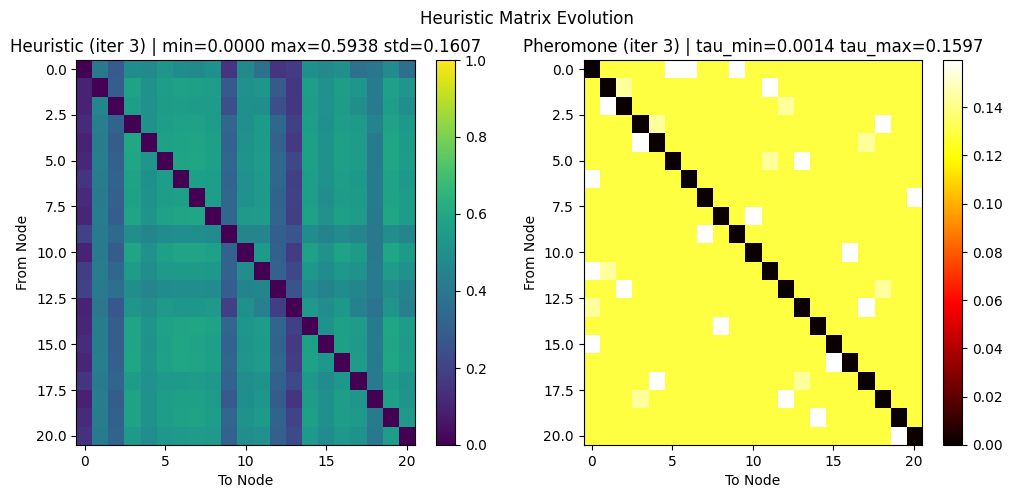

<Figure size 640x480 with 0 Axes>

Iter 4: heu std=0.160642, best_cost=6.4351, tau=[0.0014, 0.1597]


In [ ]:
n_ants = 20
n_node = 20
k_sparse = 10
t_aco = [1, 10, 50, 100]
test_list = load_test_dataset(n_node, device)

net = Net(value_head=True, use_state_edge_features=True).to(device)
net.load_state_dict(torch.load(f'../pretrained/cvrp/cvrp{n_node}_ppo_gae.pt', map_location=device))
avg_aco_best, duration = test(test_list, net, n_ants, t_aco, visualize=True, show_timing=True)
print('total duration: ', duration)
for i, t in enumerate(t_aco):
    print("T={}, average obj. is {}.".format(t, avg_aco_best[i]))

DeepACO

In [ ]:
n_ants = 20
n_node = 20
k_sparse = 10
t_aco = [1, 10, 50, 100]
test_list = load_test_dataset(n_node, device)

net = Net_DeepACO().to(device)
net.load_state_dict(torch.load(f'../pretrained/cvrp/cvrp{n_node}.pt', map_location=device))
avg_aco_best, duration = test_deepaco(test_list, net, n_ants, t_aco)
print('total duration: ', duration)
for i, t in enumerate(t_aco):
    print("T={}, average obj. is {}.".format(t, avg_aco_best[i])) 
  

  0%|          | 0/100 [00:00<?, ?it/s]

total duration:  120.70868515968323
T=1, average obj. is 5.081987380981445.
T=10, average obj. is 4.84982967376709.
T=50, average obj. is 4.803032398223877.
T=100, average obj. is 4.793013095855713.


NGFACO

ACO

In [ ]:
n_ants = 20
n_node = 20
k_sparse = 10
t_aco = [1, 10, 50, 100]
test_list = load_test_dataset(n_node, device)

net = Net(value_head=True, use_state_edge_features=True).to(device)
net.load_state_dict(torch.load(f'../pretrained/cvrp/cvrp{n_node}_ppo_gae.pt', map_location=device))
avg_aco_best, duration = test(test_list, net, n_ants, t_aco)
print('total duration: ', duration)
for i, t in enumerate(t_aco):
    print("T={}, average obj. is {}.".format(t, avg_aco_best[i]))

  0%|          | 0/100 [00:00<?, ?it/s]

total duration:  71.1493182182312
T=1, average obj. is 5.239306449890137.
T=10, average obj. is 4.719290733337402.
T=50, average obj. is 4.617067813873291.
T=100, average obj. is 4.609489917755127.


In [ ]:
n_ants = 20
n_node = 20
k_sparse = 10
t_aco = [1, 10, 50, 100]
test_list = load_test_dataset(n_node, device)


avg_aco_best, duration = test(test_list, None, n_ants, t_aco)
print('total duration: ', duration)
for i, t in enumerate(t_aco):
    print("T={}, average obj. is {}.".format(t, avg_aco_best[i]))    

  0%|          | 0/100 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute 'eval'

### Test with Visualization (Single Instance)

### Timing Analysis (First Instance)

In [ ]:
n_ants = 20
n_node = 20
k_sparse = 10
t_aco = [1, 50, 100]  # Shorter test for timing analysis
test_list = load_test_dataset(n_node, device)

# Load model
net = Net(value_head=True, use_state_edge_features=True).to(device)
net.load_state_dict(torch.load(f'../pretrained/cvrp/cvrp{n_node}_ppo_gae.pt', map_location=device))

print("Running test with timing breakdown in progress bar...")
print("=" * 60)

# Test with timing enabled - timing info will show in the tqdm progress bar
avg_aco_best, duration = test(test_list[:100], net, n_ants, t_aco, visualize=False, show_timing=True)

print("=" * 60)
print(f"Total duration: {duration:.2f}s")
for i, t in enumerate(t_aco):
    print(f"T={t}, avg cost: {avg_aco_best[i]:.2f}")

Running test with timing breakdown in progress bar...


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
n_ants = 20
n_node = 20
k_sparse = 10
t_aco = [1, 10, 50, 100]
test_list = load_test_dataset(n_node, device)

# Load model
net = Net(value_head=True, use_state_edge_features=True).to(device)
net.load_state_dict(torch.load(f'../pretrained/cvrp/cvrp{n_node}_ppo_gae.pt', map_location=device))

# Test with visualization enabled (will only visualize first instance)
avg_aco_best, duration = test(test_list[:1], net, n_ants, t_aco, visualize=True)
print('total duration: ', duration)
for i, t in enumerate(t_aco):
    print("T={}, average obj. is {:.2f}.".format(t, avg_aco_best[i]))

NameError: name 'load_test_dataset' is not defined